<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2022

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 3 <br>
American Sign Language Image Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
			<br/><br/>
Deadline:  
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
<br>
<font size=3 color=grey>
Author: Sayeh Jarollahi
</font>
                <br/>
    </div>

In [1]:
# Set your student number
student_number = 98106542
Name = 'Seeed'
Last_Name = 'Razavi'

In this question, you will train a neural network for classifying sign language images. The American  Sign Language (ASL) dataset consists of 2515 images from different numbers and alphabets. The images are in RGB format and are not the same size. The dataset is classified into 36 classes (10 numbers and 26 alphabets). 

You will need to train a model to classify this dataset into different categories. You are allowed to use MLP as well as CNN networks. 

**Grading Policy:** For a full mark on this assignment, your notebook should be completely runnable by the TA. Additionally, you must reach an accuracy of %96 on the test data.

It is highly recommended to use google colab and utilize its GPUs. However, if you want to run the notebook locally, you can reach and download the dataset in this [link](https://drive.google.com/file/d/11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5/view?usp=share_link).



## Setup


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, transform
from IPython.display import clear_output

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from q1_helper_code import get_files

#########################################
#                                       #
#  import other necessery packages here #
#                                       #
#########################################
import torch.utils.data as data
import copy
import warnings
warnings.filterwarnings("ignore")

In [3]:
# NOTE: It is highly recommended to use colab GPUs!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## configurations

In [4]:
config = {
  
    'batch_size' : 64 , 
    'num_workers' : 1 ,
    'num_classes' : 36 ,
    'epoches' : 40 ,
    'learning_rate' : 0.0005
}

## Download and unzip the dataset


In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5" -O asl_dataset.zip && rm -rf /tmp/cookies.txt
! unzip asl_dataset.zip


In [6]:
main_dir = "asl_dataset/asl_dataset"
class_dirs = os.listdir(main_dir)

## Transform 

Data transformation is the process of converting data from one format or structure into another format or structure. Transformers change pixel values but still keep almost the whole information of the image.[source](https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4) You can read more about them in the mentioned source. 

You are going to implement two different transformers from scratch. These transformers will be used once the data is loaded. 

### Resize 
This transformer recieves a tensor (3\*x\*y) and returns a tensor with shape (3\*size\*size)

In [7]:
from matplotlib.transforms import Transform
class Resize(object):
    
    def __init__(self, size=227):
        
       self.size=size
    
  
    def __call__(self, x):
        '''
        This function recieves a tensor and applies the resizing on that and returns that tensor
        '''
        
        resized=cv2.resize(np.array(x), (self.size, self.size))
        resized=torch.tensor(np.float32(resized))

        return resized

### GrayScale
This transform is helpful to decrease the number of channels, so the training gets faster. 

Feel free to add args to functions or change them if you need to!

In [8]:
class GrayScale(object):

    def __init__(self):
        pass
    def __call__(self,img):
        
        if(img.shape[0]==3):
            r,g,b=img[0,:,:],img[1,:,:],img[2,:,:]
            grayscale=1/3*(r+g+b)
        #--------------------    
        else : 
          grayscale=img    
        
        return grayscale

## Load Data and compose transforms 
You can combine Transforms using the **compose** method in the torchvision.transforms library.

In [9]:
# Ddd the implemented transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    GrayScale(),Resize()
])

Plot one random sample from each class of the datset:

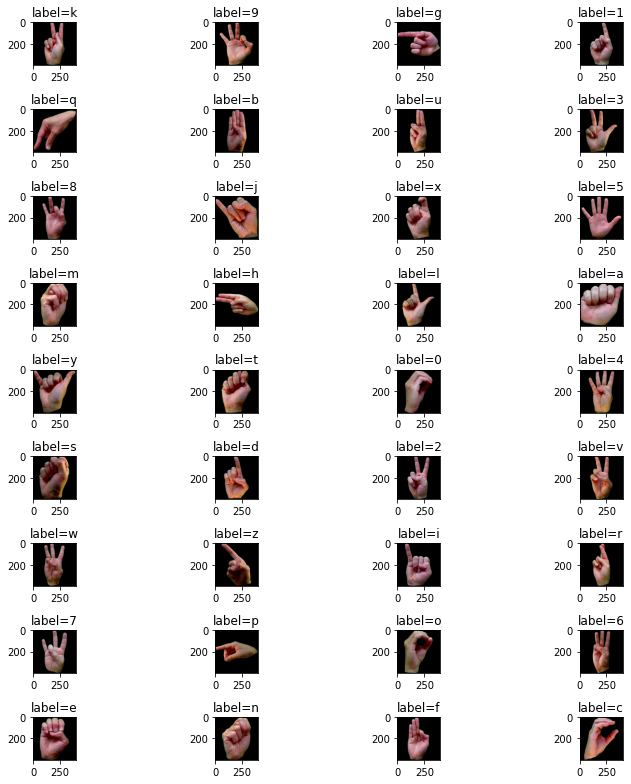

In [10]:
'''
Hint:
Get two random samples from files in each directory and use subplot to add those
images to the plot. 
Use previously defined transform to test your transforms
'''
plt.figure(figsize=(11,11))
labels_arr=[]
for i, directory in enumerate(class_dirs):
    # name of all files in the directory
    files_name = os.listdir(f"{main_dir}/{directory}")
    #############################
    #         Code here         #
    #############################
    plt.subplot(9, 4, i + 1)
    plt.tight_layout()
    im=plt.imread(f"{main_dir}/{directory}/{files_name[0]}")
    plt.imshow(im)
    plt.title(f"label={directory}")

# plt.show()


## Create Dataset 
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. [from [Pytorch Documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)] 

In this section, you will implement a custom dataset which gets address of files and loads them as needed. 

In [11]:
class ASLDataset(Dataset):
    def __init__(self, files_address:list, transform=None):
        
        self.transform=transform
        self.dirs = files_address


    def __len__(self):
        # returns length of the data

        return len(self.dirs)

    def __getitem__(self, idx):
      
        # Remember to apply transforms!
        image = plt.imread(self.dirs[idx])
        dir=self.dirs[idx].split("/")[2]
        label = int(dir) if dir.isdigit() else (ord(dir) - 87)
       
        if self.transform:
            image = self.transform(np.float32(image))

        return image, label

In [12]:
files_addr, labels = get_files()
print(len(labels), len(files_addr))

2515 2515


In [13]:
dataset = ASLDataset(files_addr,transform)

### test transforms on one sample

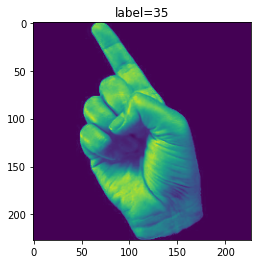

<class 'torch.Tensor'>


In [14]:
img,label=dataset.__getitem__(1800)
plt.imshow(img)
plt.title(f"label={label}")
plt.show()
print(type(img))

## Create Datasets  

First split data to train, validation and test using the `train_test_split funciton`. Remember to shuffle data. Then create ASLDataset for each part of data. 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(files_addr, labels, test_size=0.2, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4) # 0.25 x 0.8 = 0.2
#--------------------------
train_dataset = ASLDataset(x_train,transform)
val_dataset = ASLDataset(x_val,transform)
test_dataset = ASLDataset(x_test,transform)


Use datasets to create DataLoader from `torch.utils.DataLoader` class

Note: You should make `shuffle=True` for the training dataLoader, so in each epoch the data reshuffles. 

In [16]:
num_threads = 4
#-----------------
train_loader = data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=num_threads) 
val_loader =  data.DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=num_threads)
test_loader = data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=num_threads) 

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define Model 

In [17]:
class ASLModel(nn.Module):
    def __init__(self, in_channels, num_classes=36):

        super(ASLModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
            
        
           
    def forward(self, x):
        x= x.unsqueeze(1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
     

In [18]:
in_channels = 1 
num_classes = 36
model = ASLModel(in_channels, num_classes).to(device)

## Define optimizer, Criterion and other parameters 


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)

In [20]:
# Set parameters and hyper parameters
batch_size = config['batch_size']
learning_rate = config['learning_rate']
# input_size = None 

### measure accuracy

In [21]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.reshape(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

### train and evaluate the accuracy/loss in each epoch

In [22]:
best_model = None
best_acc = 0

def train_val (model, trainloader, val_loader, f_loss, optimizer, n_epochs, device = device):

    total_step_val = len(val_loader) 
    total_step_train = len(trainloader) 
    #----------------------------
    train_loss_arr, val_loss_arr = [], []
    train_acc_arr, val_acc_arr = [], []  
    best_model=copy.deepcopy(model)
    model.train()

    for epoch in range(n_epochs):
      
        sum_of_loss=0
        sum_acc1=0
        sum_acc5=0
        #-----------------
        for i, (images, labels) in enumerate(trainloader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels =  labels.to(device)

            
            #--Forward pass
            outputs = model(images)
            #----measure acc
            acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
            sum_acc1+=float(acc1)
            sum_acc5+=float(acc5)
            #----measure loss 
            loss = criterion(outputs, labels)
            sum_of_loss+=float(loss)
            #----Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #---------------------------    
        train_loss=float(sum_of_loss/total_step_train)
        train_loss_arr.append(train_loss)
        train_acc_arr.append(sum_acc1 / total_step_train)
        
    
        model.eval()
        # measure acc on val_set                 #-------------------------------------
                                                 #-------------  test  ----------------
        with torch.no_grad():                    #-------------------------------------

            sum_acc1=0
            sum_acc5=0
            sum_of_loss=0

            for i,(images, labels) in  enumerate(val_loader):
                images = images.to(device)
                labels =  labels.to(device)

                # Forward pass
                outputs = model(images)

                # measure loss 
                loss = criterion(outputs, labels)
                sum_of_loss+=float(loss)

                # measure acc
                acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
                sum_acc1+=float(acc1)
                sum_acc5+=float(acc5)

                del images, labels, outputs
            val_loss=float(sum_of_loss/total_step_val)

            val_loss_arr.append(val_loss)
            val_acc_arr.append(sum_acc1 / total_step_val)
            best_model
            

        best_model=model if (sum_acc1 / total_step_val)>=np.max(val_acc_arr) else best_model

        print(f"[Epoch {epoch}]\t"
            f"Train Loss: {train_loss:.3f}\t"
            f"Validation Loss: {val_loss:.3f}")
    return train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr,best_model

In [23]:
# Call the train_val function
train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr,final_model=train_val(model,train_loader,val_loader,criterion,optimizer,config['epoches'])

[Epoch 0]	Train Loss: 3.575	Validation Loss: 3.532
[Epoch 1]	Train Loss: 3.429	Validation Loss: 3.314
[Epoch 2]	Train Loss: 2.777	Validation Loss: 1.909
[Epoch 3]	Train Loss: 1.421	Validation Loss: 0.837
[Epoch 4]	Train Loss: 0.749	Validation Loss: 0.487
[Epoch 5]	Train Loss: 0.477	Validation Loss: 0.461
[Epoch 6]	Train Loss: 0.297	Validation Loss: 0.218
[Epoch 7]	Train Loss: 0.256	Validation Loss: 0.255
[Epoch 8]	Train Loss: 0.201	Validation Loss: 0.301
[Epoch 9]	Train Loss: 0.151	Validation Loss: 0.166
[Epoch 10]	Train Loss: 0.148	Validation Loss: 0.145
[Epoch 11]	Train Loss: 0.076	Validation Loss: 0.139
[Epoch 12]	Train Loss: 0.061	Validation Loss: 0.146
[Epoch 13]	Train Loss: 0.060	Validation Loss: 0.125
[Epoch 14]	Train Loss: 0.065	Validation Loss: 0.120
[Epoch 15]	Train Loss: 0.046	Validation Loss: 0.082
[Epoch 16]	Train Loss: 0.024	Validation Loss: 0.105
[Epoch 17]	Train Loss: 0.022	Validation Loss: 0.079
[Epoch 18]	Train Loss: 0.012	Validation Loss: 0.080
[Epoch 19]	Train Loss:

## Plot loss and accuracy

You must have one plot for loss according to epoch for train/val.

Also, another plot for accuracy according to epoch for train/val

In [24]:
def acc_loss_plot(loss_val,acc1_val,loss_train,acc1_train):
    #define horizental axis
    x_axis=np.array([i for i in np.arange(1,config['epoches']+1)])
    
    #---plot loss function for train and test set in each epoch
    plt.plot(x_axis, loss_train,label="trian loss")
    plt.plot(x_axis, loss_val,label="validation loss")
    plt.legend(loc="upper right")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("loss on train and test set")
    plt.show()
    #--------------------------------

    #---plot acc@1 for train and test set in each epoch
    plt.plot(x_axis, acc1_train,label="trian accuracy")
    plt.plot(x_axis, acc1_val,label="validation accuracy")
    plt.legend(loc="upper left")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("acc@1 on train and test set")
    
    plt.show()

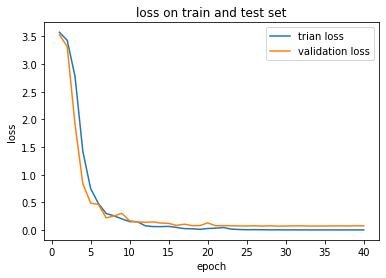

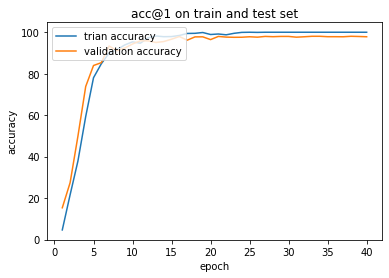

In [25]:
acc_loss_plot(val_loss_arr,val_acc_arr,train_loss_arr,train_acc_arr)

## Evaluate model on the test dataset

Evaluate your best model on the test dataset. You should get accuracy above ***%96*** for a full-mark.

Remember to print the accuracy of model on the test dataset! 

In [28]:
final_model.eval()
# measure acc on test_set                                                             
with torch.no_grad():                   

            sum_acc1=0
            for i,(images, labels) in  enumerate(test_loader):
                images = images.to(device)
                labels =  labels.to(device)

                # Forward pass
                outputs = final_model(images)

                # measure acc
                acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
                sum_acc1+=float(acc1)
                del images, labels, outputs

            final_acc=sum_acc1 / len(test_loader)
            
print(f"accuracy on test set is : {final_acc}")            


accuracy on test set is : 97.4609375
